In [1]:
# HIDDEN
using CSV
using DataFrames
using LaTeXStrings
using Statistics
using StatsPlots
Base.displaysize() = (5, 80)

## Loss Minimization Using a Program

Let us return to our constant model:

$$
\theta = C
$$

We will use the mean squared error loss function:

$$
\begin{aligned}
L(\theta, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - \theta)^2\\
\end{aligned}
$$

For simplicity, we will use the dataset $ \textbf{y} = [ 12, 13, 15, 16, 17 ] $. We know from our analytical approach in a previous chapter that the minimizing $ \theta $ for the MSE is $ \text{mean}(\textbf{y}) = 14.6 $. Let's see whether we can find the same value by writing a program.

If we write the program well, we will be able to use the same program on any loss function in order to find the minimizing value of $ \theta $, including the mathematically complicated Huber loss:

$$
L_\alpha(\theta, \textbf{y}) = \frac{1}{n} \sum_{i=1}^n \begin{cases}
    \frac{1}{2}(y_i - \theta)^2 &  | y_i - \theta | \le \alpha \\
    \alpha ( |y_i - \theta| - \frac{1}{2}\alpha ) & \text{otherwise}
\end{cases}
$$

First, we create a rug plot of the data points using our recipe defined in chapter 6. To the right of the rug plot we plot the MSE for different values of $ \theta $.

In [2]:
# HIDDEN
@userplot RugPlot
@recipe function f(rp::RugPlot, n::Integer = 1)
    data = rp.args[1]
    
    seriestype := :sticks
    ylims := (0, n)
    legend --> false
    y = fill(0.2, length(data))
    data, y
end

function mse(theta, y_vals)
    return mean([(y_val - theta) ^ 2 for y_val in y_vals])
end

function points_and_loss(y_vals, xlim, loss_fn)
    thetas = range(xlim[1], xlim[2] + 0.01, step=0.05)
    losses = [loss_fn(theta, y_vals) for theta in thetas]
    
    p1 = rugplot(y_vals)
    plot!(xlabel="Tip Percent", title="Points")
    p2 = plot(thetas, losses)
    plot!(xlabel=L"\theta", ylabel="Loss", title=typeof(loss_fn).name.mt.name, legend=false)
    
    plot(p1, p2, layout = (1, 2))
end;

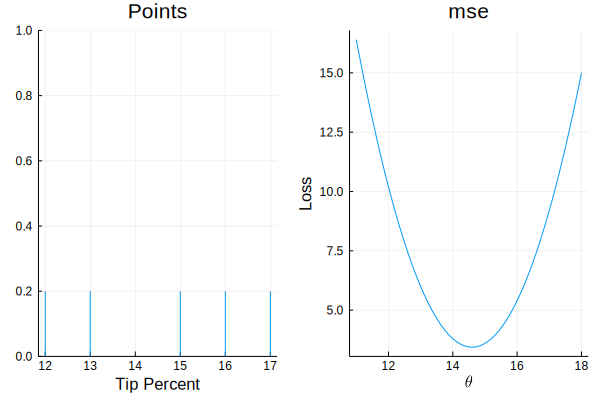

In [3]:
# HIDDEN
using Statistics
pts = [12, 13, 15, 16, 17]
points_and_loss(pts, (11, 18), mse)

How might we write a program to automatically find the minimizing value of $ \theta $? The simplest method is to compute the loss for many values $ \theta $. Then, we can return the $ \theta $ value that resulted in the least loss.

We define a function called `simple_minimize` that takes in a loss function, an array of data points, and an array of $\theta$ values to try.

In [4]:
"""
Returns the value of theta in thetas that produces the least loss on the given data.
"""
function simple_minimize(loss_fn, data, thetas)
    losses = [loss_fn(theta, data) for theta in thetas]
    return thetas[argmin(losses)]
end;

Then, we can define a function to compute the MSE and pass it into `simple_minimize`.

In [5]:
function mse(theta, y_vals)
    return mean([(y_val - theta) ^ 2 for y_val in y_vals])
end

data = [12, 13, 15, 16, 17]
thetas = range(12, 17.9, step=0.1)

simple_minimize(mse, data, thetas)

14.6

Which is the expected value:

In [6]:
# Compute the minimizing theta using the analytical formula
mean(data)

14.6

Now, we can define a function to compute the Huber loss and plot the loss against $\theta $.

In [7]:
function huber_loss(theta, data, alpha = 1)
    d = abs.(theta .- data)
    return mean(ifelse.(d .< alpha, (theta .- data) .^ 2 / 2.0, alpha * (d .- alpha / 2.0)))
end;

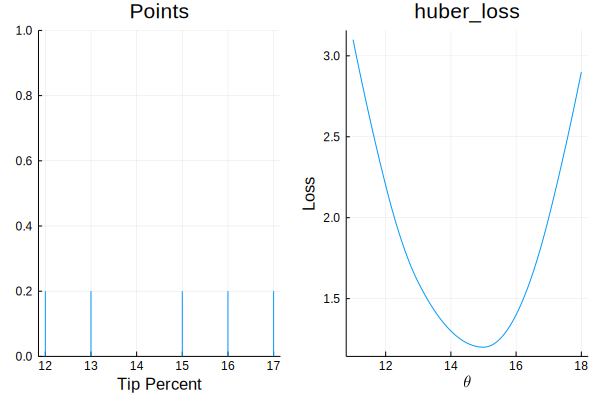

In [8]:
# HIDDEN
points_and_loss(pts, (11, 18), huber_loss)

Although we can see that the minimizing value of $ \theta $ should be close to 15, we do not have an analytical method of finding $ \theta $ directly for the Huber loss. Instead, we can use our `simple_minimize` function.

In [9]:
simple_minimize(huber_loss, data, thetas)

15.0

Now, we can return to our original dataset of tip percentages and find the best value for $ \theta $ using the Huber loss.

In [10]:
using RDatasets
tips = dataset("reshape2", "tips")
tips[!, :pcttip] = tips.Tip ./ tips.TotalBill*100
tips

,TotalBill,Tip,Sex,Smoker,Day,Time,Size
,Float64,Float64,Categorical…,Categorical…,Categorical…,Categorical…,Int32
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.5,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


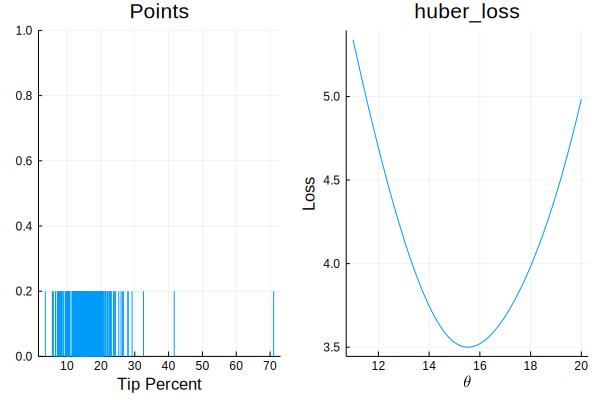

In [11]:
# HIDDEN
points_and_loss(tips.pcttip, (11, 20), huber_loss)

In [12]:
simple_minimize(huber_loss, tips.pcttip, thetas)

15.5

We can see that using the Huber loss gives us $ \hat{\theta} = 15.5 $. We can now compare the minimizing $\hat{\theta} $ values for MSE, MAE, and Huber loss.

In [25]:
using Printf
@printf("       MSE: theta_hat = %0.2f \n", mean(tips.pcttip))
@printf("       MAE: theta_hat = %0.2f \n", median(tips.pcttip))
@printf("Huber loss: theta_hat = 15.50")

       MSE: theta_hat = 16.08 
       MAE: theta_hat = 15.48 
Huber loss: theta_hat = 15.50

We can see that the Huber loss is closer to the MAE since it is less affected by the outliers on the right side of the tip percentage distribution:

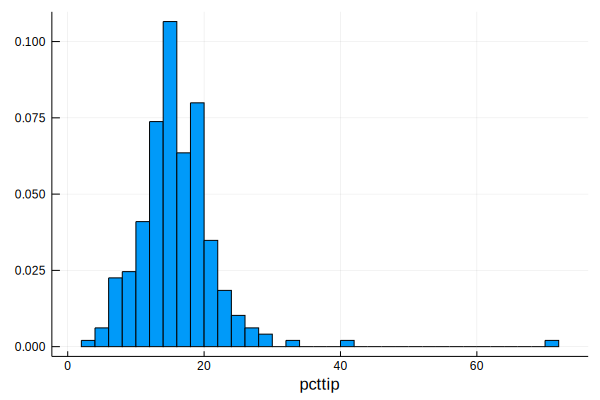

In [30]:
@df tips histogram(:pcttip, norm=:pdf, bins=50, legend=false, xlabel="pcttip")

## Issues with `simple_minimize`

Although `simple_minimize` allows us to minimize loss functions, it has some flaws that make it unsuitable for general purpose use. Its primary issue is that it only works with predetermined values of $ \theta $ to test. For example, in this code snippet we used above, we had to manually define $ \theta $ values in between 12 and 18.

```julia
data = [12, 13, 15, 16, 17]
thetas = range(12, 17.9, step=0.1)

simple_minimize(mse, dataset, thetas)
```

How did we know to examine the range between 12 and 18? We had to inspect the plot of the loss function manually and see that there was a minima in that range. This process becomes impractical as we add extra complexity to our models. In addition, we manually specified a step size of 0.1 in the code above. However, if the optimal value of $ \theta $ were 12.043, our `simple_minimize` function would round to 12.00, the nearest multiple of 0.1. 

We can solve both of these issues at once by using a method called *gradient descent*.